This file analyze the results for regression.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from scipy.stats import ttest_ind
from collections import defaultdict as ddict
from easydict import EasyDict as edict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT

In [3]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl, load_pkl, spec_emb_red

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

In [4]:
# gtvdn
import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_singular_vals, update_kp

## Load data

In [5]:
results = load_pkl(RES_ROOT/"./CPD_results_detect_first.pkl")

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method1/../../mypkg/../results/CPD_results_detect_first.pkl


In [6]:
cpts_ADs = results.AD.cpts 
candidate_pts_ADs = results.AD.candidate_pts 
ndXmats_AD = results.AD.ndXmats 
nXmats_AD = results.AD.nXmats 
CPDresult_AD = results.AD.CPDres 

cpts_ctrls = results.ctrl.cpts 
candidate_pts_ctrls = results.ctrl.candidate_pts 
ndXmats_ctrl = results.ctrl.ndXmats 
nXmats_ctrl = results.ctrl.nXmats 
CPDresult_ctrl = results.ctrl.CPDres 


B1 = CPDresult_ctrl[0]
B2 = CPDresult_ctrl[1]

# update parameters 
paras.update(results.paras)

In [7]:
# Combine info from B1 and B2 together
# Reduce dim, col by col
# it is better than together
com_Us = []
for ix in range(20):
    curU, curV = B1[:, ix], B2[:, ix]
    both_info = np.stack([curU, curV]).T
    com_U = spec_emb_red(both_info)
    com_Us.append(np.squeeze(com_U))
com_Us = np.array(com_Us).T

In [88]:
#(dont run this)
# Combine info from B1 and B2 together
# Reduce dim, all together
both_UV = np.stack([B1.T.flatten(), B2.T.flatten()]).T
com_Us_vec = np.squeeze(spec_emb_red(both_UV))
com_Us = com_Us_vec.reshape(-1, 68).T

In [219]:
# not good. 
# little regions

#com_Us = np.sqrt(B1**2+B2**2)

In [8]:
post_paras = results.post_paras

singular_vals_ADs = results.AD.singular_vals 
cpts_ADs_selected =  results.AD.cpts_selected 
dwells_ADs_selected =  results.AD.dwells_selected 
rank_ADs = results.AD.ranks 

singular_vals_ctrls = results.ctrl.singular_vals 
cpts_ctrls_selected =  results.ctrl.cpts_selected 
dwells_ctrls_selected =  results.ctrl.dwells_selected 
rank_ctrls = results.ctrl.ranks 

In [9]:
post_results = edict()
post_results.AD = edict()
post_results.ctrl = edict()
post_results.com_Us = com_Us

<AxesSubplot:>

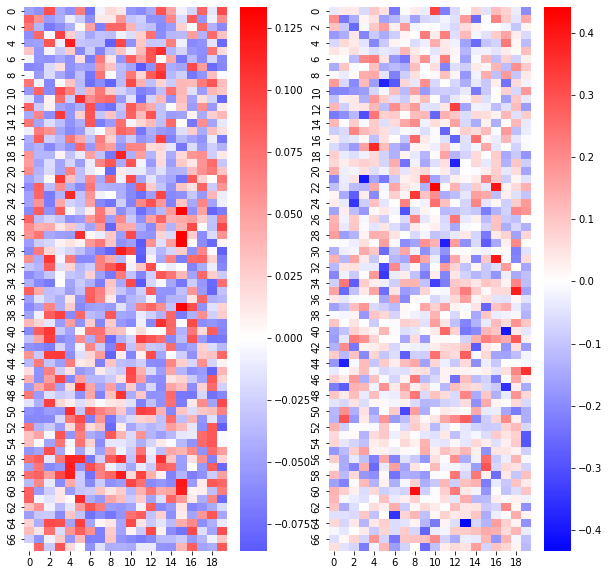

In [10]:
plt.figure(figsize=[10, 10])
plt.subplot(121)
sns.heatmap(com_Us, cmap="bwr", center=0)
plt.subplot(122)
sns.heatmap(B1, cmap="bwr", center=0)

## get the dataset

In [11]:
ncpts_ADs_selected = [len(cpts) for cpts in cpts_ADs_selected]
ncpts_ctrls_selected = [len(cpts) for cpts in cpts_ctrls_selected]

In [93]:
cur_cutoff = post_paras.rank_curoff
# selected U and calculate weighted U (ABS wU)
#cur_cutoff = 1.2
wUs_abs_AD = []
wUs_abs_mean_AD = []
wUs_abs_max_AD = []
ws_abs_mean_AD = []
ws_abs_max_AD = []
for ix in range(len(singular_vals_ADs)):
    cur_singular_val_abs = np.abs(singular_vals_ADs[ix])
    cur_raw_B3row = np.abs(CPDresult_AD[-1][ix, :])
    cur_keep_idx = cumsum_cutoff(cur_raw_B3row, cur_cutoff)
    #cur_keep_idx = minmax(cur_raw_B3row) > cur_cutoff
    cur_dwells = dwells_ADs_selected[ix]
    
    cur_ws_abs = cur_singular_val_abs[cur_keep_idx, :]
    #cur_Us_abs = np.array(B1[:, cur_keep_idx])
    cur_Us_abs = np.array(com_Us[:, cur_keep_idx])
    
    cur_wUs_abs = np.matmul(cur_Us_abs, cur_ws_abs)
    #cur_wUs_abs_raw = cur_Us_abs[:, :, np.newaxis] *  cur_ws_abs[np.newaxis, :, :]
    #cur_wUs_abs = np.array([np.squeeze(spec_emb_red(cur_wUs_abs_raw[:, :, ix])) 
    # for ix 
    # in range(cur_wUs_abs_raw.shape[-1])]).T
    cur_wUs_abs_mean = cur_wUs_abs.mean(axis=1)
    
    wUs_abs_AD.append(cur_wUs_abs)
    wUs_abs_max_AD.append(cur_wUs_abs[:, np.argmax(cur_dwells)])
    wUs_abs_mean_AD.append(cur_wUs_abs_mean)
    ws_abs_mean_AD.append(cur_ws_abs[:, :].mean())
    ws_abs_max_AD.append(cur_ws_abs[:, :].max())
    
wUs_abs_ctrl = []
wUs_abs_mean_ctrl = []
wUs_abs_max_ctrl = []
ws_abs_mean_ctrl = []
ws_abs_max_ctrl = []
for ix in range(len(singular_vals_ctrls)):
    cur_singular_val_abs = np.abs(singular_vals_ctrls[ix])
    cur_raw_B3row = np.abs(CPDresult_ctrl[-1][ix, :])
    cur_keep_idx = cumsum_cutoff(cur_raw_B3row, cur_cutoff)
    #cur_keep_idx = minmax(cur_raw_B3row) > cur_cutoff
    cur_dwells = dwells_ctrls_selected[ix]
    
    cur_ws_abs = cur_singular_val_abs[cur_keep_idx, :]
    #cur_Us_abs = np.array(B1[:, cur_keep_idx])
    cur_Us_abs = np.array(com_Us[:, cur_keep_idx])
    
    cur_wUs_abs = np.matmul(cur_Us_abs, cur_ws_abs)
    #cur_wUs_abs_raw = cur_Us_abs[:, :, np.newaxis] *  cur_ws_abs[np.newaxis, :, :]
    #cur_wUs_abs = np.array([np.squeeze(spec_emb_red(cur_wUs_abs_raw[:, :, ix])) 
    # for ix 
    # in range(cur_wUs_abs_raw.shape[-1])]).T
    cur_wUs_abs_mean = cur_wUs_abs.mean(axis=1)
    
    wUs_abs_ctrl.append(cur_wUs_abs)
    wUs_abs_max_ctrl.append(cur_wUs_abs[:, np.argmax(cur_dwells)])
    wUs_abs_mean_ctrl.append(cur_wUs_abs_mean)
    ws_abs_mean_ctrl.append(cur_ws_abs[:, :].mean())
    ws_abs_max_ctrl.append(cur_ws_abs[:, :].max())
    
wUs_abs_mean_AD = np.array(wUs_abs_mean_AD)
wUs_abs_mean_ctrl = np.array(wUs_abs_mean_ctrl)
wUs_abs_max_AD = np.array(wUs_abs_max_AD)
wUs_abs_max_ctrl = np.array(wUs_abs_max_ctrl)

## Regression 

In [94]:
# prepare for Y and X
reg_Y = np.concatenate([np.ones_like(rank_ADs), np.zeros_like(rank_ctrls)])
reg_X_B3 = np.concatenate([
                minmax_mat(np.abs(CPDresult_AD[2]), is_row=True),
                minmax_mat(np.abs(CPDresult_ctrl[2]), is_row=True)
            ], axis=0)
reg_X_wU_abs_mean = np.concatenate([wUs_abs_mean_AD, wUs_abs_mean_ctrl], axis=0)
reg_X_wU_abs_max = np.concatenate([wUs_abs_max_AD, wUs_abs_max_ctrl], axis=0)
reg_X_rank = np.concatenate([rank_ADs, rank_ctrls])
reg_X_ncpts = np.concatenate([ncpts_ADs_selected, ncpts_ctrls_selected])
reg_X_ws_max = np.concatenate([ws_abs_max_AD, ws_abs_max_ctrl])
reg_X_ws_mean = np.concatenate([ws_abs_mean_AD, ws_abs_mean_ctrl])


reg_X = np.concatenate([reg_X_rank.reshape(-1, 1), reg_X_ncpts.reshape(-1, 1)], axis=1)
reg_X = np.concatenate([
                        reg_X_wU_abs_max, 
                        reg_X_rank.reshape(-1, 1), 
                        reg_X_ncpts.reshape(-1, 1), 
                        #reg_X_ws_max.reshape(-1, 1)
                       ], axis=1)
#reg_X = reg_X_wU_abs_max
reg_X_std = (reg_X - reg_X.mean(axis=0))/reg_X.std(axis=0)

In [95]:
import numbers
# return the predicted probs for each test obs
def clf_2probs(clf, X_test):
    probs = clf.predict_proba(X_test)
    return probs[:, clf.classes_==1].reshape(-1)

def LOO_pred_givenC(cur_X, cur_Y, Cs=1, is_prg=True):
    probs = []
    if is_prg:
        prog_bar = trange(len(cur_Y))
    else:
        prog_bar = range(len(cur_Y))
    if isinstance(Cs, numbers.Number):
        Cs = np.ones_like(cur_Y)*Cs
    for ix in prog_bar:
        cur_X_test = cur_X[ix, :].reshape(1, -1)
        cur_Y_test = cur_Y[ix].reshape(1, -1)
        cur_X_train = np.delete(cur_X, ix, axis=0)
        cur_Y_train = np.delete(cur_Y, ix)
        clf = LogisticRegression(random_state=0, C=Cs[ix], penalty="l2", solver="liblinear").fit(cur_X_train, cur_Y_train)
        #clf = RandomForestClassifier(random_state=0).fit(cur_X_train, cur_Y_train)
        #clf = DecisionTreeClassifier(random_state=0).fit(cur_X_train, cur_Y_train)
        probs.append(clf_2probs(clf, cur_X_test))
    return np.array(probs).reshape(-1)

In [96]:
def LOO_bestC(cur_X, cur_Y, Cs, is_prg=0, is_C_only=1):
    Cs = np.array(Cs)
    cur_aucs = []
    if is_prg:
        prog_bar = tqdm(Cs)
    else:
        prog_bar = Cs
    for cur_C in prog_bar: 
        cur_pred_probs = LOO_pred_givenC(cur_X, cur_Y, Cs=cur_C, is_prg=0)
        cur_auc = roc_auc_score(cur_Y, cur_pred_probs)
        cur_aucs.append(cur_auc)
        cur_best_C = Cs[np.argmax(cur_aucs)]
    cur_best_C = Cs[np.argmax(cur_aucs)]
    if is_C_only:
        return cur_best_C
    else:
        return cur_best_C, cur_aucs

### AUC under LOO

In [97]:
Cs = paras.Cs[:11]
paras.Cs = np.concatenate([Cs, [5e-3, 1e-3]])

In [98]:
gopt_C = LOO_bestC(reg_X_std, reg_Y, paras.Cs, 1)
print(gopt_C)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]

0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 744.77it/s]


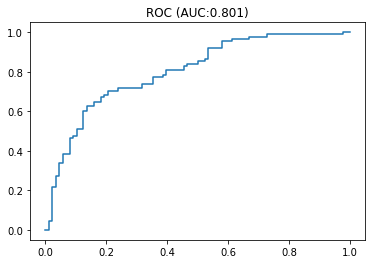

In [99]:
pred_probs = LOO_pred_givenC(reg_X_std, reg_Y, Cs=gopt_C, is_prg=1)
fpr, tpr, thresholds = roc_curve(reg_Y, pred_probs, pos_label=1)
auc = roc_auc_score(reg_Y, pred_probs)

plt.title(f"ROC (AUC:{auc:.3f})")
plt.plot(fpr, tpr)

### CV for tuning C for each Obs

In [100]:
import multiprocessing as mp
def run_fn(ix):
    cur_X_test = reg_X_std[ix, :].reshape(1, -1)
    cur_Y_test = reg_Y[ix].reshape(1, -1)
    cur_X_train = np.delete(reg_X_std, ix, axis=0)
    cur_Y_train = np.delete(reg_Y, ix)
    
    print(ix)
    cur_best_C =  LOO_bestC(cur_X_train, cur_Y_train, paras.Cs, 0)
    return (ix, cur_best_C)


if __name__ == "__main__":
    with mp.Pool(processes=20) as pool:
        res = pool.map(run_fn, list(range(len(reg_Y))))
    pool.join()

639120
15


3318
2421
39

514548
4257
54


36
30




27


Process ForkPoolWorker-2:
Process ForkPoolWorker-19:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-7:
Process ForkPoolWorker-18:
Process ForkPoolWorker-11:
Process ForkPoolWorker-5:


KeyboardInterrupt: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 839.34it/s]


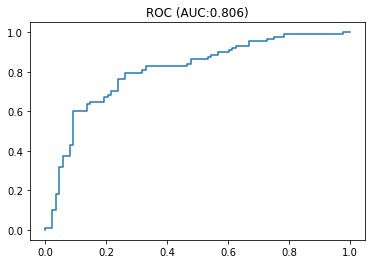

In [19]:
res = sorted(res, key=lambda x:x[0])
best_Cs = [re[-1] for re in res]

probs = []
pred_probs = LOO_pred_givenC(reg_X_std, reg_Y, Cs=best_Cs, is_prg=1)
fpr, tpr, thresholds = roc_curve(reg_Y, pred_probs, pos_label=1)
auc = roc_auc_score(reg_Y, pred_probs)

plt.title(f"ROC (AUC:{auc:.3f})")
plt.plot(fpr, tpr)

### AUC under 10000 CV

In [101]:
# AUC under repetitions
np.random.seed(0)
nobs = reg_X_std.shape[0]
rep_aucs = []
for j in tqdm(range(10000)):
    test_idxs = np.random.choice(nobs, int(nobs/5), False)
    train_idxs = np.delete(np.arange(nobs), test_idxs)
    clf = LogisticRegression(penalty=paras.penalty, random_state=0, C=gopt_C, solver="liblinear")
    clf.fit(reg_X_std[train_idxs], reg_Y[train_idxs])
    cur_eprobs = clf_2probs(clf, reg_X_std[test_idxs, :])
    cur_auc = roc_auc_score(reg_Y[test_idxs], cur_eprobs)
    rep_aucs.append(cur_auc)
mean_auc = np.mean(rep_aucs)
std_auc = np.std(rep_aucs)
print(f"The mean of AUC under 1000 repetitions is {mean_auc:.3f} and the standard deviation is {std_auc:.3f}, "
      f"the 95% CI is ({np.quantile(rep_aucs, 0.025):.3f}, {np.quantile(rep_aucs, 0.975):.3f}).")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 617.39it/s]

The mean of AUC under 1000 repetitions is 0.796 and the standard deviation is 0.070, the 95% CI is (0.648, 0.920).


### final fit  and bootstrap analysis

In [102]:
final_clf = LogisticRegression(random_state=0, C=gopt_C, penalty="l2", solver="liblinear").fit(reg_X_std, reg_Y)
final_coefs = final_clf.coef_.reshape(-1)

In [103]:
# bootstrap CIs
np.random.seed(1)
rep_num = 10000
parass_boot = []
for _ in trange(rep_num):
    boot_idx = np.random.choice(len(reg_Y), len(reg_Y))
    cur_Y_boot = reg_Y[boot_idx]
    cur_X_boot = reg_X_std[boot_idx]
    cur_clf = LogisticRegression(penalty=paras.penalty, random_state=0, C=gopt_C, solver="liblinear")
    cur_clf.fit(cur_X_boot, cur_Y_boot)
    paras_boot = cur_clf.coef_.reshape(-1)
    parass_boot.append(paras_boot)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1020.16it/s]


In [104]:
from scipy.stats import norm
parass_boot = np.array(parass_boot)
# 95% CIs
lows, ups = final_coefs-parass_boot.std(axis=0)*1.96, final_coefs+parass_boot.std(axis=0)*1.96
keep_idx_boot = np.bitwise_or(lows >0,  ups < 0)
keep_idx_id_boot =  np.where(keep_idx_boot)[0]

# Pvalue
test_stat_boot = final_coefs/parass_boot.std(axis=0)
norm_rv = norm()
# to be consistent, I think we should use two-sided pvalue
boot_pvs = 2*(1-norm_rv.cdf(np.abs(test_stat_boot)))

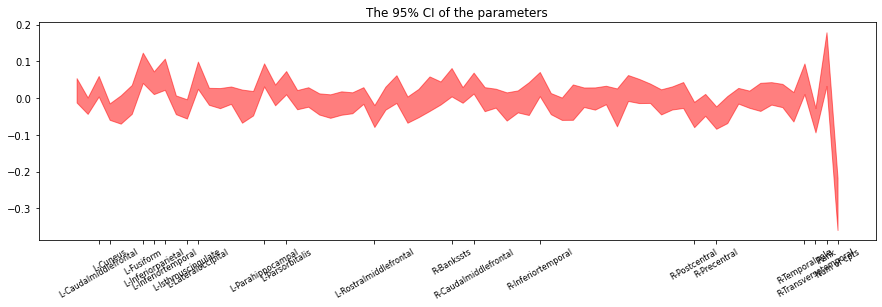

In [105]:
xlabs = np.concatenate([REGION_NAMES, ["Rank", "Num of cpts"]])
#xlabs = np.concatenate([region_names, ["Rank", "Num of cpts", "Lambda"]])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(keep_idx_id_boot, xlabs[keep_idx_id_boot], rotation=30, fontsize=8)

In [106]:
# Bootstrap p value and CI are consistent
tmp_idx = np.bitwise_xor(boot_pvs <= 0.05, keep_idx_boot)
res_tb = {
   "Feature" : xlabs[tmp_idx],  
    "Parameters": final_coefs[tmp_idx],
    "Lower": lows[tmp_idx],
    "Upper": ups[tmp_idx],
    "Pvalues": boot_pvs[tmp_idx]
}
pd.set_option("display.precision", 3)
res_tb = pd.DataFrame(res_tb)
print(res_tb)

Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []


In [107]:
#  output table
res_tb = {
   "Feature" : xlabs[keep_idx_boot],  
    "Parameters": final_coefs[keep_idx_boot],
    "Lower": lows[keep_idx_boot],
    "Upper": ups[keep_idx_boot],
    "Pvalues": boot_pvs[keep_idx_boot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.4f' % x)
res_tb = pd.DataFrame(res_tb)
print(res_tb)

                   Feature  Parameters   Lower   Upper  Pvalues
0    L-Caudalmiddlefrontal      0.0326  0.0047  0.0605   0.0222
1                 L-Cuneus     -0.0364 -0.0589 -0.0140   0.0014
2               L-Fusiform      0.0827  0.0415  0.1240   0.0001
3       L-Inferiorparietal      0.0422  0.0113  0.0730   0.0075
4       L-Inferiortemporal      0.0653  0.0229  0.1077   0.0026
5       L-Isthmuscingulate     -0.0290 -0.0552 -0.0029   0.0297
6       L-Lateraloccipital      0.0626  0.0256  0.0997   0.0009
7        L-Parahippocampal      0.0634  0.0320  0.0948   0.0001
8          L-Parsorbitalis      0.0422  0.0105  0.0739   0.0090
9   L-Rostralmiddlefrontal     -0.0486 -0.0783 -0.0188   0.0014
10              R-Bankssts      0.0435  0.0050  0.0821   0.0270
11   R-Caudalmiddlefrontal      0.0411  0.0126  0.0696   0.0047
12      R-Inferiortemporal      0.0384  0.0055  0.0714   0.0221
13           R-Postcentral     -0.0444 -0.0788 -0.0101   0.0113
14            R-Precentral     -0.0527 -

In [108]:
# final parameter, no abs, remove pv <0.05
mm_pn_paras = minmax(np.abs(final_coefs[:68]))
nlog_pvs = -np.log10(boot_pvs[:68])
mm_pn_paras[nlog_pvs < -np.log10(0.05)] = 0
out_paras = U_2brain_vec(reorder_U(mm_pn_paras))
print(np.sum(mm_pn_paras ==0), np.sum(nlog_pvs < -np.log10(0.05)))
np.savetxt(RES_ROOT/"./finalOPParas1.txt", out_paras)
#pd.DataFrame({"Name": region_names, "Vec": mm_pn_paras}).to_csv(paras.res_dir/"./finalOPParas1.csv", index=False)

51 51


In [109]:
!cp ../../results/finalOPParas1.txt  ../../../../Documents/MATLAB/gTVDN/map_fils/

In [91]:
mm_pn_paras

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.95884695, 0.53126384, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.62393368, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.82119183,
       0.        , 0.53841165, 0.        , 0.        , 0.        ,
       0.72429493, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.56293752, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.73304072, 0.        ])

In [61]:
mm_pn_paras

array([0.        , 0.50270761, 0.        , 0.        , 0.78842115,
       0.        , 0.60156815, 0.        , 0.        , 0.        ,
       0.8871782 , 0.51729537, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.30026353, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.44250063, 0.        ,
       0.52729224, 0.        , 0.        , 0.66177418, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.55824172, 0.        , 0.        , 0.81933806,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.69050099, 0.94216946, 0.55215331,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.6763868 ])

## Save

In [ ]:
results.post_results = post_results
save_pkl(RES_ROOT/"./CPD_results_detect_first.pkl", results, True)

Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method1/../../mypkg/../results/CPD_results_detect_first.pkl
